# Classification Task for single target compounds + Explaination

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
DATASET_TYPE = "single" #"single"
DATASET_NAME = "chembl29_predicting_target_P14416_P42336"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
print(smiles_df.head())

                     nonstereo_aromatic_smiles    target_pair  label
0  Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1  P14416_P42336      0
1      Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12  P14416_P42336      0
2  Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1  P14416_P42336      0
3   Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1  P14416_P42336      0
4         Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1  P14416_P42336      0


## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [3]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [4]:
target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]

chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336.csv: 100%|██████████| 7634/7634 [00:00<00:00, 86840.29it/s]
Constructing molecules from SMILES: 100%|██████████| 7633/7633 [00:30<00:00, 248.28it/s]


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

C:\Users\Mastro\AppData\Local\Temp\ipykernel_2260\3959976721.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(chembl_dataset.smiles_list))):


  0%|          | 0/7633 [00:00<?, ?it/s]

[(0, 'Br'), (1, 'C'), (2, 'C'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'N'), (7, 'C'), (8, 'C'), (9, 'N'), (10, 'C'), (11, 'C'), (12, 'N'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (17, 'C'), (18, 'C'), (19, 'C'), (20, 'C'), (21, 'C'), (22, 'N'), (23, 'C'), (24, 'C'), (25, 'C'), (26, 'C')]


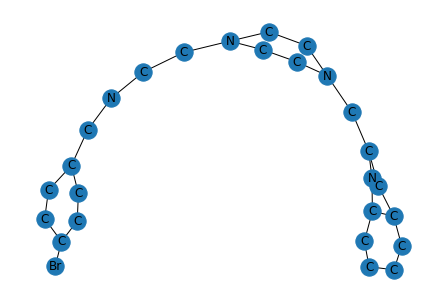

In [5]:
from pysmiles import read_smiles
import networkx as nx
from tqdm import tqdm_notebook as tqdm
    
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))

mol = mols[0]
print(mol.nodes(data='element'))
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, labels = labels, pos=nx.spring_layout(mol))

Define edge index 

In [6]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

C:\Users\Mastro\AppData\Local\Temp\ipykernel_2260\3079298363.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mol in tqdm(mols):


  0%|          | 0/7633 [00:00<?, ?it/s]

7633

Define torchdrug dataset in order to get node features

In [7]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


C:\Users\Mastro\AppData\Local\Temp\ipykernel_2260\3720085538.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(chembl_dataset.smiles_list))):


  0%|          | 0/7633 [00:00<?, ?it/s]

## Create Custom Dataset

In [8]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


C:\Users\Mastro\AppData\Local\Temp\ipykernel_2260\1993559842.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(mols))):


  0%|          | 0/7633 [00:00<?, ?it/s]

In [9]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

        # Read data into huge `Data` list.
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [10]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [11]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] : ]
len(train_data), len(val_data), len(test_data)

[6106, 763, 764]


(6106, 763, 764)

In [12]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## GCN Definition

In [14]:
from torch_geometric.nn import GCNConv, Linear

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(256, 2, bias=True)
)


## GIN Definition (to fix)

In [15]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool


class GIN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GIN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GINConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GINConv(hidden_channels, hidden_channels)
        self.conv3 = GINConv(hidden_channels, hidden_channels)
        self.conv4 = GINConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GIN(hidden_channels=256).to(device)
print(model)

GIN(
  (conv1): GINConv(nn=69)
  (conv2): GINConv(nn=256)
  (conv3): GINConv(nn=256)
  (conv4): GINConv(nn=256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Training Phase

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=256).to(device)

lr = lr=1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 10
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.9656, Val Acc: 0.9594
Epoch: 001, Train Acc: 0.9784, Val Acc: 0.9751
Epoch: 002, Train Acc: 0.9769, Val Acc: 0.9777
Epoch: 003, Train Acc: 0.9844, Val Acc: 0.9830
Epoch: 004, Train Acc: 0.9692, Val Acc: 0.9699
Epoch: 005, Train Acc: 0.9836, Val Acc: 0.9843
Epoch: 006, Train Acc: 0.9761, Val Acc: 0.9790
Epoch: 007, Train Acc: 0.9903, Val Acc: 0.9869
Epoch: 008, Train Acc: 0.9931, Val Acc: 0.9882
Epoch: 009, Train Acc: 0.9859, Val Acc: 0.9856
Test Acc: 0.9882


## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.nn import GNNExplainer

torch.manual_seed(42)

test_cpd = test_data[0].to(device)
#model = Net().to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 100/100 [00:02<00:00, 47.03it/s]


### Plot Explaination Subgraph

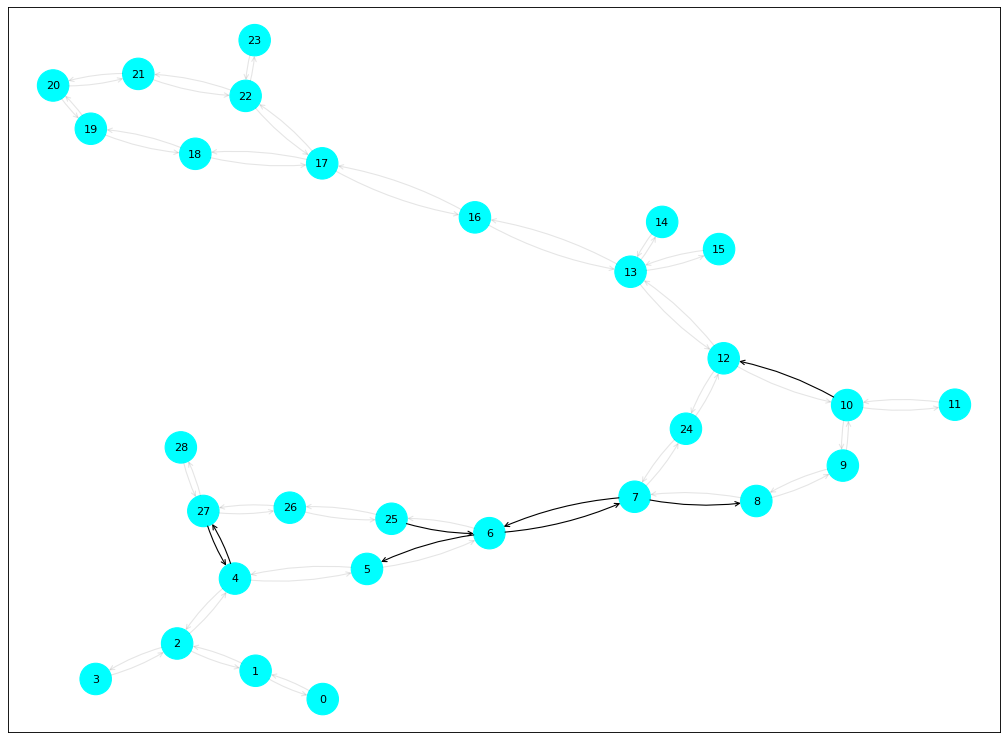

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)
threshold = 0.8
edge_mask = edge_mask.to("cpu")
ax, G = explainer.visualize_subgraph(edge_index = edge_index, edge_mask = edge_mask, node_idx = -1, y=None, threshold=threshold)
plt.show()

tensor([[ 9],
        [12],
        [13],
        [15],
        [16],
        [24],
        [54],
        [58]])
tensor([[ 4,  6,  6,  7,  7, 10, 25, 27],
        [27,  5,  7,  6,  8, 12,  6,  4]], device='cuda:0')


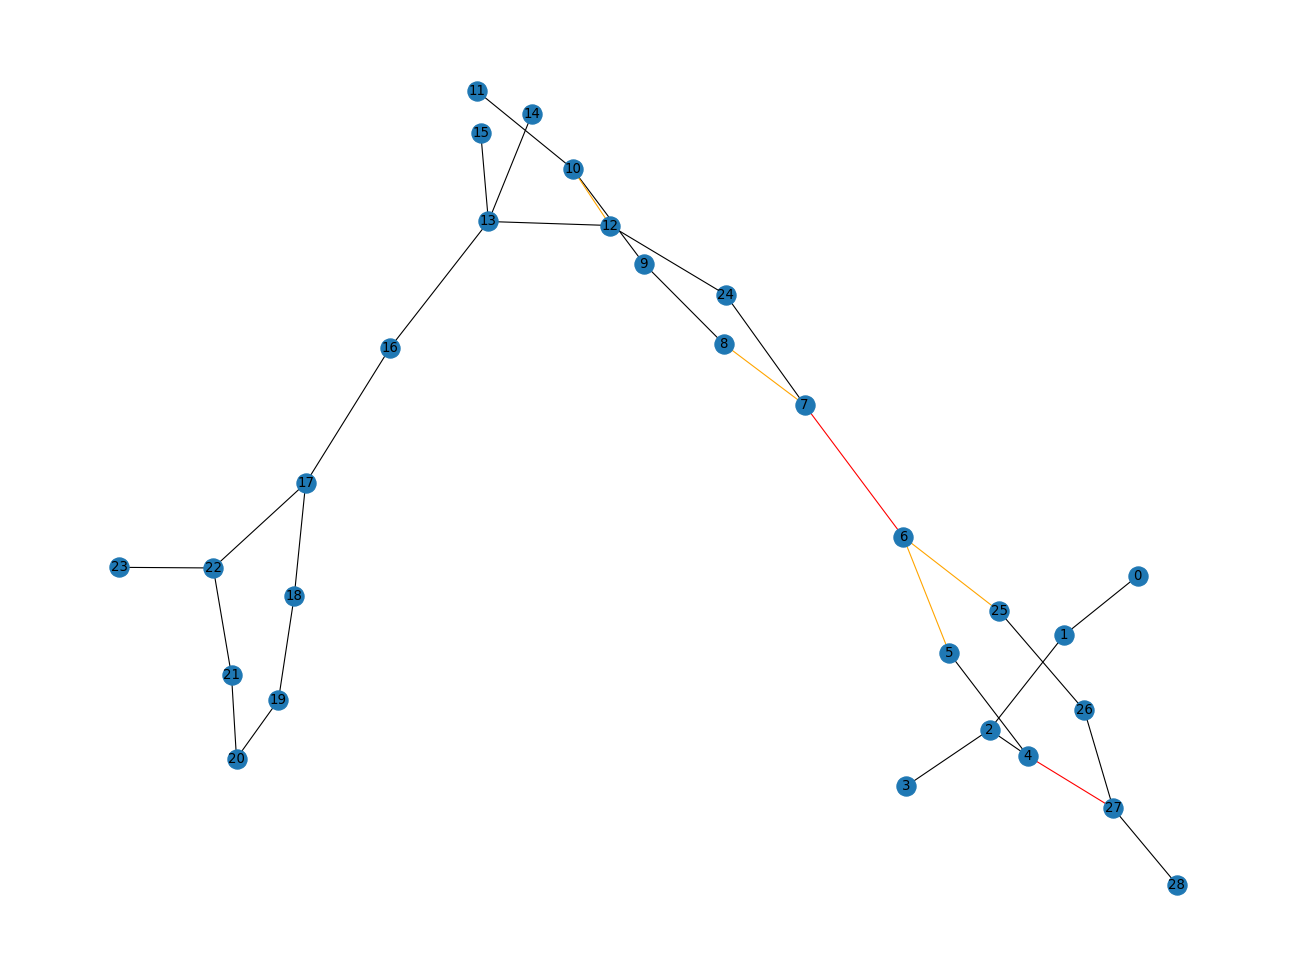

In [ ]:
hard_edge_mask = (edge_mask >= threshold).to(torch.float)
hard_edge_mask.shape

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = edge_index.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

## GraphSHAPer

Explain the graph classification using Shaply values for edges.
Determine the contribution of each edge towards the output value (predicted problability)

Starting point:

TODO:

* Method 1 (jackknife-style sampling): compute approx shapley value for edge $e$ considering all possibile coalitions of $E - 1$ edges, where $E$ is the number of edges.
* Method 2 (montecarlo sampling)
* Method 3 (exahustive search)
* Method 4 (node sampling): sample a number of nodes and work in the nodes k-hop subgraph similarly to a node classification explanation 